In [0]:
!pip install xmltodict
import urllib.request as ul
import requests
from bs4 import BeautifulSoup
import pandas as pd
import xmltodict
import json

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
weather_url = "http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList?serviceKey=1uXwwpob3LYCWyzve%2BLRowi3FZ0EaSDcic5XDUzen4mT1U52fWKUb2s9JverFIrAAE9wStxx7F7%2BQJIbLamC0w%3D%3D&pageNo=1&numOfRows=160&dataType=XML&dataCd=ASOS&dateCd=DAY&startDt=20200101&endDt=20200601&stnIds=108&"
resp = requests.get(weather_url)
soup = BeautifulSoup(resp.text, 'lxml')
day_list =soup.select('items item tm')
humid_list = soup.select('items item avgrhm')
max_temperature_list =soup.select('items item maxta')
min_temperature_list =soup.select('items item minta')
pressure_list =soup.select('items item avgpv')

# humid_list
city_list =soup.select('items stnNm')
weather_list={
    'day':[],
    'max_temperature':[],
    'min_temperature':[],
    'pressure':[],
    'humid':[]
}
for d in day_list:
  weather_list['day'].append(d.text)
for th in max_temperature_list:
  weather_list['max_temperature'].append(th.text)
for tl in min_temperature_list:
  weather_list['min_temperature'].append(tl.text)
for p in pressure_list:
  weather_list['pressure'].append(p.text)
for h in humid_list:
  weather_list['humid'].append(h.text)

날짜 데이터 합치는 과정에서 형식 통일 위해
string 으로 변경 후 , replace 사용하여 8자리 숫자로 통일해 주었음.

In [0]:
weather = pd.DataFrame(weather_list)
weather['day'] = weather['day'].str.replace('-', '')
weather

,day,max_temperature,min_temperature,pressure,humid
0,20200101,0.3,-6.5,3.4,64.4
1,20200102,3.8,-0.7,4.3,65.4
2,20200103,4.6,-3.4,3.3,56.9
3,20200104,6.1,-2.8,3.3,50.8
4,20200105,6.6,-3.2,3.0,45.6
...,...,...,...,...,...
148,20200528,23.4,14.2,13.0,62.8
149,20200529,27.6,14.6,15.5,65.6
150,20200530,30.0,16.5,15.0,57.3
151,20200531,28.0,17.6,15.4,63.0


인코딩 문제로 인한 url service key error 해결<br>
상기 날씨 데이터와 코로나 확진자 수 데이터 merge

In [0]:
My_Key = 'W9jIMRzMDO5%2BloYGqUOtdLYE8s9CbKBhSagwjPqq5k4OuCHzeCssqO0ZX63UjtwI6BVkmF3F4IGTaU8Kx%2BQzlQ%3D%3D'
decoded_Key = requests.utils.unquote(My_Key)
#-*- coding:utf-8 -*-
api_url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson?serviceKey=W9jIMRzMDO5%2BloYGqUOtdLYE8s9CbKBhSagwjPqq5k4OuCHzeCssqO0ZX63UjtwI6BVkmF3F4IGTaU8Kx%2BQzlQ%3D%3D&pageNo=1&numOfRows=100&startCreateDt=20200101&endCreateDt=20200607&'
params = {
    'ServiceKey' : decoded_Key,
    'pageNo' : 1,
    'startCreateDt' : 20200101,
    'endCreateDt' : 20200607
}

resp = requests.get(api_url, params)
soup = BeautifulSoup(resp.text, 'lxml')
data = soup.select('item stateDt')
data = xmltodict.parse(resp.text)

itemList = data['response']['body']['items']['item']
a =[]
for item in itemList:
  a.append(item['stateDt'])#날짜
b=[]
for item in itemList:
    b.append(item['decideCnt']) #확진자수
data_df=pd.DataFrame({'day' : a , 'corona': b})
data_df

,day,corona
0,20200607,11776
1,20200606,11719
2,20200605,11668
3,20200604,11629
4,20200603,11590
...,...,...
157,20200205,18
158,20200204,0
159,20200203,15
160,20200202,2


In [0]:
wea_cor = weather.merge(data_df, on='day') #열 중에 같은 name
wea_cor

,day,max_temperature,min_temperature,pressure,humid,corona
0,20200101,0.3,-6.5,3.4,64.4,0
1,20200202,5.3,-2.1,3.4,52.3,2
2,20200203,3.0,-2.9,2.6,43.6,15
3,20200204,3.9,-6.0,2.9,50.3,0
4,20200205,-4.9,-11.0,1.2,37.3,19
...,...,...,...,...,...,...
151,20200528,23.4,14.2,13.0,62.8,11344
152,20200529,27.6,14.6,15.5,65.6,11402
153,20200530,30.0,16.5,15.0,57.3,11441
154,20200531,28.0,17.6,15.4,63.0,11468


json 활용하여 미세먼지 지수와 대기오염경보를 크롤링 하여 위의 결과값과 merge 해주었다.

In [0]:
#-*- coding: utf-8 -*-
url = 'http://openapi.airkorea.or.kr/openapi/services/rest/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty?serviceKey=mLEwFeh06vTA9DAwEwAYp0Es%2F8tV40muxH79%2FuLI3L0JPytMG5RqkfP37z5%2BvhAN%2F5yuIxby%2BqhbNgMB9CHflw%3D%3D&numOfRows=50000&pageNo=1&stationName=%EC%A2%85%EB%A1%9C%EA%B5%AC&dataTerm=3MONTH&ver=1.3&_returnType=json'
response = ul.urlopen(url)
json_str = response.read().decode('utf-8')
json_object = json.loads(json_str)
fine_dust = pd.json_normalize(json_object['list'])

fine_dust.columns
fine_dust

,_returnType,coGrade,coValue,dataTerm,dataTime,khaiGrade,khaiValue,mangName,no2Grade,no2Value,numOfRows,o3Grade,o3Value,pageNo,pm10Grade,pm10Grade1h,pm10Value,pm10Value24,pm25Grade,pm25Grade1h,pm25Value,pm25Value24,resultCode,resultMsg,rnum,serviceKey,sidoName,so2Grade,so2Value,stationCode,stationName,totalCount,ver
0,json,1,0.8,,2020-06-10 10:00,2,79,도시대기,2,0.047,10,1,0.025,1,2,3,94,59,2,2,34,27,,,0,,,1,0.005,,,,
1,json,1,1.1,,2020-06-10 09:00,2,77,도시대기,2,0.045,10,1,0.016,1,2,2,73,51,2,2,31,26,,,0,,,1,0.004,,,,
2,json,1,0.5,,2020-06-10 08:00,2,79,도시대기,2,0.039,10,1,0.014,1,2,2,54,50,2,2,27,27,,,0,,,1,0.004,,,,
3,json,1,0.5,,2020-06-10 07:00,2,79,도시대기,2,0.040,10,1,0.009,1,2,2,49,49,2,2,27,27,,,0,,,1,0.004,,,,
4,json,1,0.5,,2020-06-10 06:00,2,79,도시대기,2,0.031,10,1,0.014,1,2,2,45,49,2,2,25,27,,,0,,,1,0.003,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,json,1,0.6,,2020-03-10 16:00,2,59,도시대기,1,0.021,10,1,0.021,1,1,1,13,24,2,1,11,19,,,0,,,1,0.004,,,,
2203,json,1,0.5,,2020-03-10 15:00,2,61,도시대기,1,0.020,10,1,0.022,1,1,1,12,26,2,1,7,20,,,0,,,1,0.003,,,,
2204,json,1,0.5,,2020-03-10 14:00,2,72,도시대기,1,0.019,10,1,0.023,1,1,1,11,30,2,1,8,24,,,0,,,1,0.004,,,,
2205,json,1,0.5,,2020-03-10 13:00,2,85,도시대기,1,0.024,10,1,0.022,1,2,1,14,36,2,1,12,29,,,0,,,1,0.004,,,,


In [0]:
fine_dust = fine_dust[['dataTime','pm10Value','pm25Value']]
fine_dust.columns = ['day','pm10Value','pm25Value']

fine_dust['day'] = fine_dust['day'].str.replace('-','')
fine_dust['day'] = fine_dust['day'].str[:-6]
fine_dust

dust_alarm_url = 'http://openapi.airkorea.or.kr/openapi/services/rest/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo?serviceKey=iGIOTC1nCrSiqqcpFTPdUBKd%2BzQRMmWmNE0RGEq%2BcTDuIlXOMiltEzHVXr21fFbf4C7RLBF1u9%2FceAXo3S8blg%3D%3D&pageNo=1&numOfRows=500&year=2020&itemCode=&_returnType=json'
resp = ul.urlopen(dust_alarm_url)
alarm_str = resp.read().decode('utf-8')
alarm_object = json.loads(alarm_str)
dust_alarm = pd.json_normalize(alarm_object['list'])

dust_alarm = dust_alarm[['districtName','issueDate','issueTime','clearTime']]
dust_alarm = dust_alarm[dust_alarm['districtName'].isin(['서울','경기','인천'])]

dust_alarm.columns = ['districtName','day','issueTime','clearTime']
dust_alarm['day'] = dust_alarm['day'].str.replace('-','')
dust_merge = fine_dust.merge(dust_alarm, on='day')

dust_merge.head(50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,day,pm10Value,pm25Value,districtName,issueTime,clearTime
0,20200511,91,15,인천,18:00,00:00
1,20200511,91,15,인천,16:00,00:00
2,20200511,91,15,경기,13:00,01:00
3,20200511,91,15,경기,12:00,00:00
4,20200511,91,15,인천,15:00,22:00
5,20200511,91,15,서울,13:00,00:00
6,20200511,91,15,경기,14:00,01:00
7,20200511,91,15,인천,17:00,23:00
8,20200511,91,15,경기,13:00,01:00
9,20200511,126,17,인천,18:00,00:00


모든 데이터를 날씨데이터 기준으로 outer(합집합)로 merge <br>
object type을 float type으로 변환

In [0]:
all_merge = pd.merge(wea_cor,dust_merge, how='outer')
all_merge[['pm10Value','pm25Value','max_temperature','min_temperature','corona','humid','pressure']] = all_merge[['pm10Value','pm25Value','max_temperature','min_temperature','corona','humid','pressure']].apply(pd.to_numeric)

월별 데이터를 기준으로 하기 위하여 day 데이터를 월 단위까지 slicing

In [0]:
all_merge['day']=all_merge['day'].str[:-2]
all_merge.head(50)

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime
0,202001,0.3,-6.5,3.4,64.4,0,NaN,NaN,NaN,NaN,NaN
1,202002,5.3,-2.1,3.4,52.3,2,NaN,NaN,NaN,NaN,NaN
2,202002,3.0,-2.9,2.6,43.6,15,NaN,NaN,NaN,NaN,NaN
3,202002,3.9,-6.0,2.9,50.3,0,NaN,NaN,NaN,NaN,NaN
4,202002,-4.9,-11.0,1.2,37.3,19,NaN,NaN,NaN,NaN,NaN
5,202002,-4.9,-11.0,1.2,37.3,18,NaN,NaN,NaN,NaN,NaN
6,202002,0.4,-11.8,1.4,36.4,23,NaN,NaN,NaN,NaN,NaN
7,202002,2.2,-7.2,2.5,45.1,24,NaN,NaN,NaN,NaN,NaN
8,202002,2.2,-7.2,2.5,45.1,24,NaN,NaN,NaN,NaN,NaN
9,202002,3.7,-2.3,2.9,48.1,24,NaN,NaN,NaN,NaN,NaN


In [0]:
all_merge.iloc[250]

day                202004
max_temperature       8.3
min_temperature       4.1
pressure              4.4
humid                46.8
corona              10694
pm10Value              40
pm25Value               9
districtName           경기
issueTime           07:00
clearTime           15:00
Name: 250, dtype: object

In [0]:
all_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day              538 non-null    object 
 1   max_temperature  538 non-null    float64
 2   min_temperature  538 non-null    float64
 3   pressure         538 non-null    float64
 4   humid            538 non-null    float64
 5   corona           538 non-null    int64  
 6   pm10Value        384 non-null    float64
 7   pm25Value        384 non-null    float64
 8   districtName     384 non-null    object 
 9   issueTime        384 non-null    object 
 10  clearTime        384 non-null    object 
dtypes: float64(6), int64(1), object(4)
memory usage: 50.4+ KB


In [0]:
all_merge.describe(include='all')

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime
count,538,538.000000,538.000000,538.000000,538.000000,538.000000,384.000000,384.000000,384,384,384
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10,8
top,202005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경기,09:00,00:00
freq,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192,120,96
mean,NaN,15.362082,7.473048,7.679554,55.088848,9503.096654,87.895833,18.130208,NaN,NaN,NaN
std,NaN,7.072907,5.388881,3.521997,10.120593,3292.941275,46.536149,8.551715,NaN,NaN,NaN
min,NaN,-4.900000,-11.800000,1.200000,17.900000,0.000000,22.000000,6.000000,NaN,NaN,NaN
25%,NaN,8.300000,4.100000,4.400000,46.800000,10694.000000,42.000000,11.000000,NaN,NaN,NaN
50%,NaN,16.900000,6.200000,7.250000,61.000000,10694.000000,76.000000,16.000000,NaN,NaN,NaN
75%,NaN,22.000000,12.400000,10.800000,61.000000,10909.000000,132.000000,24.000000,NaN,NaN,NaN


In [0]:
all_merge.describe(include='all')

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime
count,538,538.000000,538.000000,538.000000,538.000000,538.000000,384.000000,384.000000,384,384,384
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10,8
top,202005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경기,09:00,00:00
freq,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192,120,96
mean,NaN,15.362082,7.473048,7.679554,55.088848,9503.096654,87.895833,18.130208,NaN,NaN,NaN
std,NaN,7.072907,5.388881,3.521997,10.120593,3292.941275,46.536149,8.551715,NaN,NaN,NaN
min,NaN,-4.900000,-11.800000,1.200000,17.900000,0.000000,22.000000,6.000000,NaN,NaN,NaN
25%,NaN,8.300000,4.100000,4.400000,46.800000,10694.000000,42.000000,11.000000,NaN,NaN,NaN
50%,NaN,16.900000,6.200000,7.250000,61.000000,10694.000000,76.000000,16.000000,NaN,NaN,NaN
75%,NaN,22.000000,12.400000,10.800000,61.000000,10909.000000,132.000000,24.000000,NaN,NaN,NaN


활용이 용이하도록 pandas 의 to_pickle 사용해 데이터프레임 형태로 저장

In [0]:
# df 저장
all_merge.to_pickle('all_merge.pkl')

In [0]:
#all_merge = pd.read_pickle('all_merge.pkl')

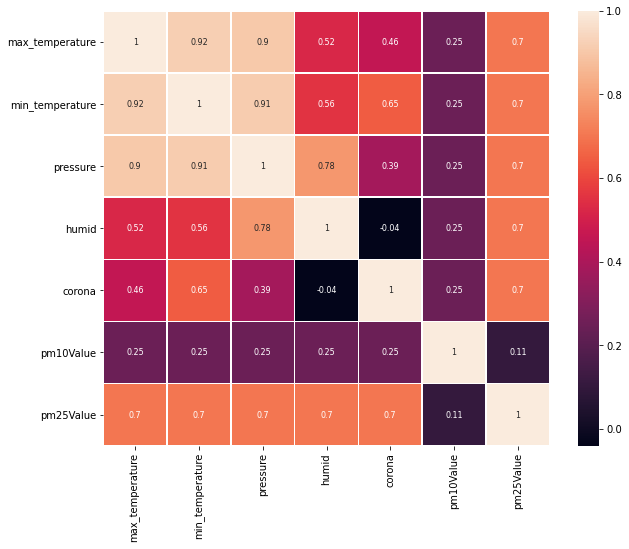

In [0]:
plt.figure(figsize=(8,7))
sns.heatmap(all_merge.corr(), annot=True, annot_kws={'size': 8}, lw=0.5)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


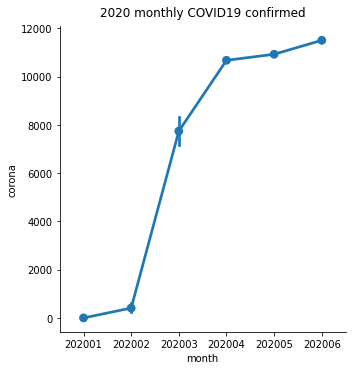

In [0]:
sns.factorplot(x='day', y='corona', data=all_merge)
plt.title('2020 monthly COVID19 confirmed',pad=10)
plt.xlabel('month')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


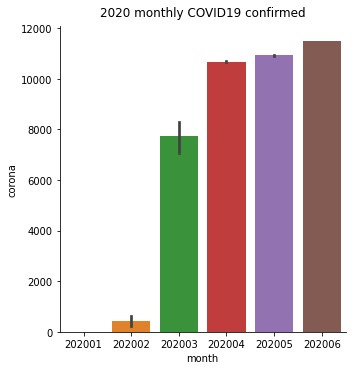

In [0]:
sns.factorplot(x='day', y='corona', data=all_merge, kind='bar')
plt.title('2020 monthly COVID19 confirmed',pad=10)
plt.xlabel('month')
plt.show()

In [0]:
all_merge[['max_temperature','pm25Value']].corr()

,max_temperature,pm25Value
max_temperature,1.000000,0.701859
pm25Value,0.701859,1.000000


**기온(max_temperature)과 미세먼지(pm25Value)의 상관관계는 0.5  이상으로 매우 높은 양의 상관관계이다.**<br>
**기온이 높을수록 미세먼지 농도도 심해진다.**

In [0]:
all_merge[['max_temperature','pm10Value']].corr()

,max_temperature,pm10Value
max_temperature,1.000000,0.245501
pm10Value,0.245501,1.000000


기온(max_temperature)과 미세먼지(pm10Value)의 상관관계가 있지만 PM2.5보다 더 약한 상관관계를 가지고 있다.

In [0]:
all_merge[['max_temperature','corona']].corr()  

,max_temperature,corona
max_temperature,1.000000,0.458912
corona,0.458912,1.000000


In [0]:
all_merge[['min_temperature','corona']].corr()

,min_temperature,corona
min_temperature,1.000000,0.645581
corona,0.645581,1.000000


In [0]:
all_merge[['pressure','corona']].corr()

,pressure,corona
pressure,1.000000,0.386143
corona,0.386143,1.000000


In [0]:
all_merge[['corona','humid']].corr()

,corona,humid
corona,1.000000,-0.039815
humid,-0.039815,1.000000


In [0]:
all_merge[['corona','pm25Value']].corr()

,corona,pm25Value
corona,1.000000,0.701859
pm25Value,0.701859,1.000000


In [0]:
all_merge[['corona','pm10Value']].corr()

,corona,pm10Value
corona,1.000000,0.245501
pm10Value,0.245501,1.000000


In [0]:
all_merge

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime
0,202001,0.3,-6.5,3.4,64.4,0,NaN,NaN,NaN,NaN,NaN
1,202002,5.3,-2.1,3.4,52.3,2,NaN,NaN,NaN,NaN,NaN
2,202002,3.0,-2.9,2.6,43.6,15,NaN,NaN,NaN,NaN,NaN
3,202002,3.9,-6.0,2.9,50.3,0,NaN,NaN,NaN,NaN,NaN
4,202002,-4.9,-11.0,1.2,37.3,19,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
533,202005,23.4,14.2,13.0,62.8,11344,NaN,NaN,NaN,NaN,NaN
534,202005,27.6,14.6,15.5,65.6,11402,NaN,NaN,NaN,NaN,NaN
535,202005,30.0,16.5,15.0,57.3,11441,NaN,NaN,NaN,NaN,NaN
536,202005,28.0,17.6,15.4,63.0,11468,NaN,NaN,NaN,NaN,NaN


In [0]:
all_merge.describe()

,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value
count,538.000000,538.000000,538.000000,538.000000,538.000000,384.000000,384.000000
mean,15.362082,7.473048,7.679554,55.088848,9503.096654,87.895833,18.130208
std,7.072907,5.388881,3.521997,10.120593,3292.941275,46.536149,8.551715
min,-4.900000,-11.800000,1.200000,17.900000,0.000000,22.000000,6.000000
25%,8.300000,4.100000,4.400000,46.800000,10694.000000,42.000000,11.000000
50%,16.900000,6.200000,7.250000,61.000000,10694.000000,76.000000,16.000000
75%,22.000000,12.400000,10.800000,61.000000,10909.000000,132.000000,24.000000
max,30.000000,18.000000,18.900000,94.400000,12801.000000,183.000000,39.000000


### continuous feature binning

기온은 연속 변수이므로 단일 bin으로 그룹화하여 카테고리 변수로 전환한다.<br>
max_temperature의 max는 30이고, min은 -4.9이므로 사이즈 7인 bin으로 분할한다.<br>

In [0]:
all_merge['max_temperature_band'] = 0
all_merge.loc[all_merge['max_temperature']<=2.0,'max_temperature_band'] = 0
all_merge.loc[(all_merge['max_temperature']>2.0)&(all_merge['max_temperature']<=9.0),'max_temperature_band']=1
all_merge.loc[(all_merge['max_temperature']>9.0)&(all_merge['max_temperature']<=16.0),'max_temperature_band']=2
all_merge.loc[(all_merge['max_temperature']>16.0)&(all_merge['max_temperature']<=23.0),'max_temperature_band']=3
all_merge.loc[all_merge['max_temperature']>23.0, 'max_temperature_band']=4
all_merge.head(2)

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime,max_temperature_band
0,202001,0.3,-6.5,3.4,64.4,0,NaN,NaN,NaN,NaN,NaN,0
1,202002,5.3,-2.1,3.4,52.3,2,NaN,NaN,NaN,NaN,NaN,1


In [0]:
all_merge.tail(2)

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime,max_temperature_band
536,202005,28.0,17.6,15.4,63.0,11468,NaN,NaN,NaN,NaN,NaN,4
537,202006,24.5,16.6,14.2,64.3,11503,NaN,NaN,NaN,NaN,NaN,4


In [0]:
all_merge.describe()

,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,max_temperature_band
count,538.000000,538.000000,538.000000,538.000000,538.000000,384.000000,384.000000,538.000000
mean,15.362082,7.473048,7.679554,55.088848,9503.096654,87.895833,18.130208,2.144981
std,7.072907,5.388881,3.521997,10.120593,3292.941275,46.536149,8.551715,1.021821
min,-4.900000,-11.800000,1.200000,17.900000,0.000000,22.000000,6.000000,0.000000
25%,8.300000,4.100000,4.400000,46.800000,10694.000000,42.000000,11.000000,1.000000
50%,16.900000,6.200000,7.250000,61.000000,10694.000000,76.000000,16.000000,3.000000
75%,22.000000,12.400000,10.800000,61.000000,10909.000000,132.000000,24.000000,3.000000
max,30.000000,18.000000,18.900000,94.400000,12801.000000,183.000000,39.000000,4.000000


In [0]:
all_merge['max_temperature_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,max_temperature_band
3,259
1,201
2,50
4,19
0,9


<br>
min_temperature의 max는 18이고, min은 -11.8이므로 사이즈가 6인 bin으로 분할한다.<br>

In [0]:
all_merge['min_temperature_band'] = 0
all_merge.loc[all_merge['min_temperature']<=-6.0,'min_temperature_band'] = 0
all_merge.loc[(all_merge['min_temperature']>-6.0)&(all_merge['min_temperature']<=0),'min_temperature_band']=1
all_merge.loc[(all_merge['min_temperature']>0)&(all_merge['min_temperature']<=6.0),'min_temperature_band']=2
all_merge.loc[(all_merge['min_temperature']>6.0)&(all_merge['min_temperature']<=12.0),'min_temperature_band']=3
all_merge.loc[all_merge['min_temperature']>12.0, 'min_temperature_band']=4
all_merge

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime,max_temperature_band,min_temperature_band
0,202001,0.3,-6.5,3.4,64.4,0,NaN,NaN,NaN,NaN,NaN,0,0
1,202002,5.3,-2.1,3.4,52.3,2,NaN,NaN,NaN,NaN,NaN,1,1
2,202002,3.0,-2.9,2.6,43.6,15,NaN,NaN,NaN,NaN,NaN,1,1
3,202002,3.9,-6.0,2.9,50.3,0,NaN,NaN,NaN,NaN,NaN,1,0
4,202002,-4.9,-11.0,1.2,37.3,19,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,202005,23.4,14.2,13.0,62.8,11344,NaN,NaN,NaN,NaN,NaN,4,4
534,202005,27.6,14.6,15.5,65.6,11402,NaN,NaN,NaN,NaN,NaN,4,4
535,202005,30.0,16.5,15.0,57.3,11441,NaN,NaN,NaN,NaN,NaN,4,4
536,202005,28.0,17.6,15.4,63.0,11468,NaN,NaN,NaN,NaN,NaN,4,4


In [0]:
all_merge['min_temperature_band'].value_counts().to_frame().style.background_gradient(cmap='RdYlGn')

,min_temperature_band
4,240
2,223
3,32
1,31
0,12


### 결측값 대체
서울을 중심으로 데이터셋을 만들었으므로 districtName의 NaN값은 서울로 대체한다.

In [0]:
# all_merge.replace({'districtName':np.nan},{'districtName':'서울'})
all_merge['districtName'].fillna('서울',inplace=True)
all_merge

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime,max_temperature_band,min_temperature_band
0,202001,0.3,-6.5,3.4,64.4,0,NaN,NaN,서울,NaN,NaN,0,0
1,202002,5.3,-2.1,3.4,52.3,2,NaN,NaN,서울,NaN,NaN,1,1
2,202002,3.0,-2.9,2.6,43.6,15,NaN,NaN,서울,NaN,NaN,1,1
3,202002,3.9,-6.0,2.9,50.3,0,NaN,NaN,서울,NaN,NaN,1,0
4,202002,-4.9,-11.0,1.2,37.3,19,NaN,NaN,서울,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,202005,23.4,14.2,13.0,62.8,11344,NaN,NaN,서울,NaN,NaN,4,4
534,202005,27.6,14.6,15.5,65.6,11402,NaN,NaN,서울,NaN,NaN,4,4
535,202005,30.0,16.5,15.0,57.3,11441,NaN,NaN,서울,NaN,NaN,4,4
536,202005,28.0,17.6,15.4,63.0,11468,NaN,NaN,서울,NaN,NaN,4,4


In [0]:
all_merge.districtName.isnull().any()

False

PM10의 mean은 87.895833, PM2.5의 mean은 18.130208이고 min부터 max까지 분위가 일정하므로 각각 NaN값을 88.0,18.0으로 대체한다.

In [0]:
all_merge['pm10Value'].fillna('88.0',inplace=True)
all_merge['pm25Value'].fillna('18.0',inplace=True )

In [0]:
all_merge

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime,max_temperature_band,min_temperature_band
0,202001,0.3,-6.5,3.4,64.4,0,88.0,18.0,서울,NaN,NaN,0,0
1,202002,5.3,-2.1,3.4,52.3,2,88.0,18.0,서울,NaN,NaN,1,1
2,202002,3.0,-2.9,2.6,43.6,15,88.0,18.0,서울,NaN,NaN,1,1
3,202002,3.9,-6.0,2.9,50.3,0,88.0,18.0,서울,NaN,NaN,1,0
4,202002,-4.9,-11.0,1.2,37.3,19,88.0,18.0,서울,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,202005,23.4,14.2,13.0,62.8,11344,88.0,18.0,서울,NaN,NaN,4,4
534,202005,27.6,14.6,15.5,65.6,11402,88.0,18.0,서울,NaN,NaN,4,4
535,202005,30.0,16.5,15.0,57.3,11441,88.0,18.0,서울,NaN,NaN,4,4
536,202005,28.0,17.6,15.4,63.0,11468,88.0,18.0,서울,NaN,NaN,4,4


### 문자열 변환
<br>
문자열을 숫자형으로 변환한다.

In [0]:
all_merge['districtName'].replace(['서울','경기','인천'],[0,1,2],inplace=True)

In [0]:
all_merge

,day,max_temperature,min_temperature,pressure,humid,corona,pm10Value,pm25Value,districtName,issueTime,clearTime,max_temperature_band,min_temperature_band
0,202001,0.3,-6.5,3.4,64.4,0,88.0,18.0,0,NaN,NaN,0,0
1,202002,5.3,-2.1,3.4,52.3,2,88.0,18.0,0,NaN,NaN,1,1
2,202002,3.0,-2.9,2.6,43.6,15,88.0,18.0,0,NaN,NaN,1,1
3,202002,3.9,-6.0,2.9,50.3,0,88.0,18.0,0,NaN,NaN,1,0
4,202002,-4.9,-11.0,1.2,37.3,19,88.0,18.0,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,202005,23.4,14.2,13.0,62.8,11344,88.0,18.0,0,NaN,NaN,4,4
534,202005,27.6,14.6,15.5,65.6,11402,88.0,18.0,0,NaN,NaN,4,4
535,202005,30.0,16.5,15.0,57.3,11441,88.0,18.0,0,NaN,NaN,4,4
536,202005,28.0,17.6,15.4,63.0,11468,88.0,18.0,0,NaN,NaN,4,4


In [0]:
all_merge['districtName'].value_counts().to_frame().style.background_gradient(cmap='gray')

,districtName
0,202
1,192
2,144


### 불필요한 feature 삭제

In [0]:
all_merge.drop(['issueTime','clearTime'],axis=1,inplace=True)

In [0]:
# 가공한 df 저장
all_merge.to_pickle('cor_dust.pkl')

In [0]:
all_merge['pm25Value'].value_counts().to_frame().style.background_gradient(cmap='RdYlGn')

,pm25Value
18.0,154
11.0,42
18.0,32
15.0,27
16.0,23
14.0,23
8.0,21
9.0,21
34.0,18
33.0,18
